# Least Absolute Shrinkage and Selection Operator (LASSO)

O objetivo desse notebook é aprender de maneira prática como utilizar os pacotes de python em um modelo de seleção de variáveis. Para isso, seguiremos um [tutorial](https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/) que pode ser encontrado na internet.

Agradeço ao autor do tutorial Jan Kirenz pela ajuda no desenvolvimento e aprendizado.

O interesse aqui de fato é o aprendizado sobre a técnica dentro da classe de modelos de mínimos quadrados penalizados do LASSO. Mas precisamos nos introduzir ao que será feito no exercício prático. A idéia aqui é prever da melhor maneira os salários dos jogadores de beisebol da Major League Baseball das temporadas de 1986 e 1987.

In [89]:
# Importação dos pacotes principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

%matplotlib inline
plt.style.use('seaborn-white')

### Introdução

Antes de iniciar, faremos uma breve introdução de como o LASSO funciona. A regressão em LASSO se assemelha muito com o modelo de regressão de Ordinary Least Squares (OLS), mas adiciona um termo de penalidade para prevenir overfitting. O ajuste do modelo usando o LASSO se dá ao otimizar a seleção de variáveis usando uma tecnica de regularização os coeficientes estimados. 

No caso do OLS a função objetivo a ser minimizada é o Residual Sum of Squares (RSS) calculado da seguinte forma:

$$
\begin{align}
\operatorname{RSS} &= \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 \\
&= \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij}\right)\right)^2
\end{align}
$$

onde $n$ é o tamanho amostral, $p$ é a quantidade de regressores (preditores).

No caso de modelos de Penalized Least Squares a função objetivo é 

$$
\begin{align}
\sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij}\right)\right)^2 + \sum_{j=1}^p p_{\lambda}(\beta_j)
\end{align}
$$

onde $p_{\lambda}$ é uma função penalidade indexado pelo regularization parameter $\lambda$ e também pode depender dos dados e de outros hiper-parâmetros (leia LASSO - Masini). 

O regularization parameter, $\lambda \in [0, \infty)$, onde $\lambda = 0$ significa que os coeficientes serão os mesmos que no caso do OLS enquanto quando $\lambda \rightarrow \infty$ significa que todos coeficientes serão nulos. 

Essa função penalidade $p_{\lambda}$ pode tomar várias formas, mas vamos focar nossa atenção em duas formas mais conhecidas, LASSO e Ridge, que respectivamente usam 

* $p_{\lambda} = |\beta_j|$ 
* $p_{\lambda} = \beta_j^2$

Essas duas funções penalidade são conhecidas também como, respectivamente, L1 Regularization e L2 Regularization.

Se olharmos para o problema como um problema restrito tal como

$$
\begin{align}
\min_{\beta_j} & \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij}\right)\right)^2 \\
& \operatorname{s.t.} \sum_{j=1}^p p_{\lambda} < c(\lambda)
\end{align}
$$

podemos visualizar graficamente um problema com dois parâmetros.

Graficamente temos a sútil diferença na restrição

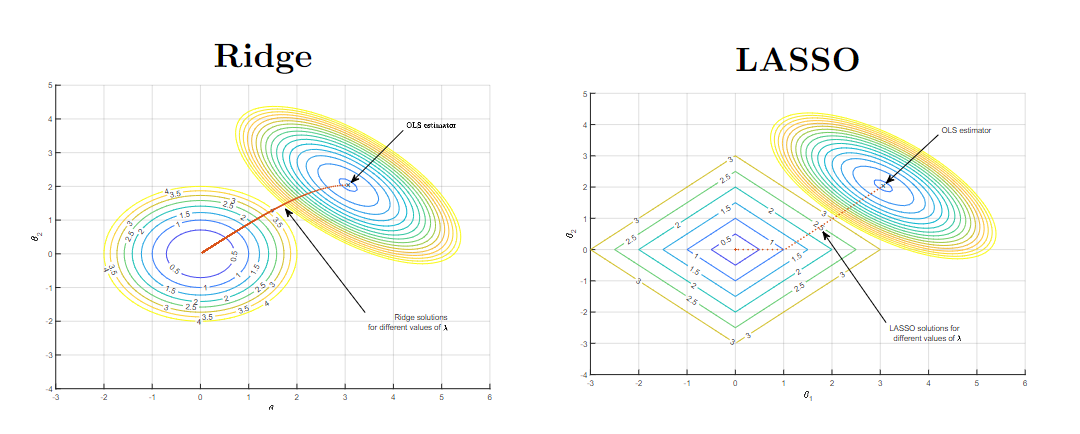

Fonte: LASSO - Masini

Para o restante do exercício usaremos a letra grega $\alpha$ como regularization parameter, comumente representado por $\lambda$, para ficar nos moldes do tutorial que seguiremos e também a documentação do pacote sklearn

### Dados

#### Importação

Introdução feita, podemos trazer nosso conjunto de dados. Vamos ilustrar o LASSO através de um exercício usando dados da Major League Baseball nas temporadas de 1986 e 1987. Essa base tem 20 variáveis as quais temos uma breve explicação do que cada uma delas retrata a seguir (veja Data Dictionary).

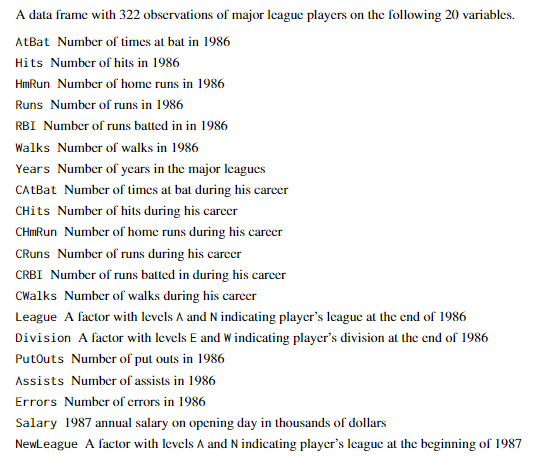

In [62]:
# Dados
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

In [63]:
# Faremos download da base apenas por precaução.
df.to_csv('Hitters.csv')

In [64]:
# vizualização das primeiras linhas do DataFrame
df.head(10)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
6,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0,A
7,298,73,0,24,24,7,3,509,108,0,41,37,12,A,W,121,283,9,100.0,A
8,323,81,6,26,32,8,2,341,86,6,32,34,8,N,W,143,290,19,75.0,N
9,401,92,17,49,66,65,13,5206,1332,253,784,890,866,A,E,0,0,0,1100.0,A


In [65]:
# breve resumo de informações sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

#### Valores NaN
Temos algumas amostras com a variável salário, cujo temos interesse em prever. Podemos simplesmente dropar esses casos sem dados.

In [66]:
# mostra quantas linhas cada coluna tem valor NaN
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [67]:
# dropando NaN's (Not A Number)
df = df.dropna()

In [68]:
# mostra quantas linhas cada coluna tem valor NaN
df.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

#### Dados Numéricos

Vale notar que três colunas, League, Division e NewLeague, tem como tipo variável categórica (object). Uma vez que usaremos o algoritmo LASSO da biblioteca scikit learn, precisamos tornar essas variáveis em numéricas (dummy variables).

In [69]:
# transforma variáveis categóricas em numéricas
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

In [70]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [71]:
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


Agora precisamos criar nossas variáveis, primeiramente a variável que temos interesse em prever comumente nomeada como y e os preditores normalmente nomeados como X.

In [72]:
y = df['Salary']

In [73]:
# dropamos tanto a variável que vamos prever e as outras três variáveis categóricas. 
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

In [74]:
# pegar o nome das colunas que já eram numéricas
list_numerical = X_numerical.columns
list_numerical

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

In [75]:
# unindo as variáveis numericas com as categóricas (já transformada em dummy)
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

#### Divisão de Dados

Agora precisamos dividir os dados em dois conjuntos, de treino e de teste, onde 70% dos dados serão destinados a treinar o modelo e os outros 30% para testá-lo.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [77]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,496.0,119.0,8.0,57.0,33.0,21.0,7.0,3358.0,882.0,36.0,365.0,280.0,165.0,155.0,371.0,29.0,1,1,1
92,317.0,78.0,7.0,35.0,35.0,32.0,1.0,317.0,78.0,7.0,35.0,35.0,32.0,45.0,122.0,26.0,0,0,0
137,343.0,103.0,6.0,48.0,36.0,40.0,15.0,4338.0,1193.0,70.0,581.0,421.0,325.0,211.0,56.0,13.0,0,0,0
90,314.0,83.0,13.0,39.0,46.0,16.0,5.0,1457.0,405.0,28.0,156.0,159.0,76.0,533.0,40.0,4.0,0,1,0
100,495.0,151.0,17.0,61.0,84.0,78.0,10.0,5624.0,1679.0,275.0,884.0,1015.0,709.0,1045.0,88.0,13.0,0,0,0


#### Padronização

LASSO performa melhor quando todas variáveis numéricas têm média 0 e variância unitária. Se a variável tem uma variância de magnitude maior que as outras, poderia dominar a função objetivo e fazer o estimador incapaz de aprender com outras variáveis corretamente, como esperado. 

Isso significa que é importante padronizar nossas variáveis. Fazemos isso a partir da seguinte equação

$$
z_i = \frac{(x_i - \bar{x})}{s}
$$

onde $x_i$ é a observação da linha $i$ da coluna $x$, $\bar{x}$ é a média da coluna $x$ e $s$ é o desvio padrão da coluna $x$.

Para evitar [*data leakage*](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), a padronização de variáveis numéricas devem sempre ser efetuado depois da divisão de dados e só para os dados de treino. Além do mais, obtemos todas estatísticas necessárias para nossas variáveis (média e desvio padrão) dos dados de treino e também as usamos nos dados de teste. Note também que não padronizamos variáveis dummies.

*data leakage*: In statistics and machine learning, leakage (also known as data leakage or target leakage) is the use of information in the model training process which would not be expected to be available at prediction time, causing the predictive scores (metrics) to overestimate the model's utility when run in a production environment. (https://en.wikipedia.org/wiki/Leakage_(machine_learning))

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])

X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [85]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,0.644577,0.257439,-0.456963,0.101010,-0.763917,-0.975959,-0.070553,0.298535,0.239063,-0.407836,0.011298,-0.163736,-0.361084,-0.482387,1.746229,3.022233,1,1,1
92,-0.592807,-0.671359,-0.572936,-0.778318,-0.685806,-0.458312,-1.306911,-1.001403,-0.969702,-0.746705,-0.957639,-0.898919,-0.844319,-0.851547,0.022276,2.574735,0,0,0
137,-0.413075,-0.105019,-0.688910,-0.258715,-0.646751,-0.081841,1.577925,0.717456,0.706633,-0.010542,0.645511,0.259369,0.220252,-0.294452,-0.434676,0.635577,0,0,0
90,-0.613545,-0.558091,0.122907,-0.618440,-0.256196,-1.211253,-0.482672,-0.514087,-0.478077,-0.501317,-0.602362,-0.526826,-0.684451,0.786178,-0.545452,-0.706917,0,1,0
100,0.637665,0.982354,0.586803,0.260888,1.227914,1.706394,0.547626,1.267183,1.437305,2.384908,1.535171,2.041811,1.615457,2.504446,-0.213124,0.635577,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.824309,0.733164,0.470829,0.740521,0.954525,0.859335,-0.688732,-0.824858,-0.808834,-0.571428,-0.787341,-0.685866,-0.648118,3.427344,0.326910,1.232241,1,0,1
196,0.423369,0.461321,1.862516,0.500704,1.618469,0.482865,1.165805,1.354814,1.246368,1.625375,1.112362,1.516681,0.681687,-1.002566,-0.822392,-1.303581,0,1,0
159,1.474109,1.254197,1.746542,1.140215,2.126191,-0.458312,-0.894792,-0.522636,-0.520174,-0.068968,-0.528958,-0.322776,-0.662651,-0.633407,1.310048,0.933909,0,1,0
17,-1.470728,-1.396275,-1.152806,-1.217982,-1.740306,-1.258312,-0.482672,-0.932153,-0.933620,-0.770075,-0.869554,-0.934928,-0.818885,-0.660255,0.403069,1.083075,0,1,0


### Regressão LASSO

Primeiro aplicaremos a regressão LASSO no conjunto de dados de treino com um parâmetro de regularização igual a um, $\alpha = 1$.

In [38]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

#### Avaliação do Modelo

Availiaremos o modelo através do coeficiente $R^2$ para o conjunto de dados de treino e de teste.

In [41]:
print('R^2 do conjunto de dados de treino', round(reg.score(X_train, y_train)*100, 2))
print('R^2 do conjunto de dados de teste', round(reg.score(X_test, y_test)*100, 2))

R^2 do conjunto de dados de treino 60.43
R^2 do conjunto de dados de teste 33.01


Também podemos avaliar o modelo através do Mean Squared Error (MSE).

In [43]:
from sklearn.metrics import mean_squared_error

# Dados de treino
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE do conjunto de dados de treino', round(mse_train, 2))

# Dados de teste
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE do conjunto de dados de teste', round(mse_test, 2))

MSE do conjunto de dados de treino 80571.73
MSE do conjunto de dados de teste 134426.33


#### Regra para o regularization parameter $\alpha$

Para enteder melhor a regra do parâmetro de regularização, vamos plotar os coeficientes do LASSO como função de $\alpha$.

In [46]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

In [47]:
# melhora a qualidade dos gráficos
sns.set(rc={'figure.figsize':(12,8)});

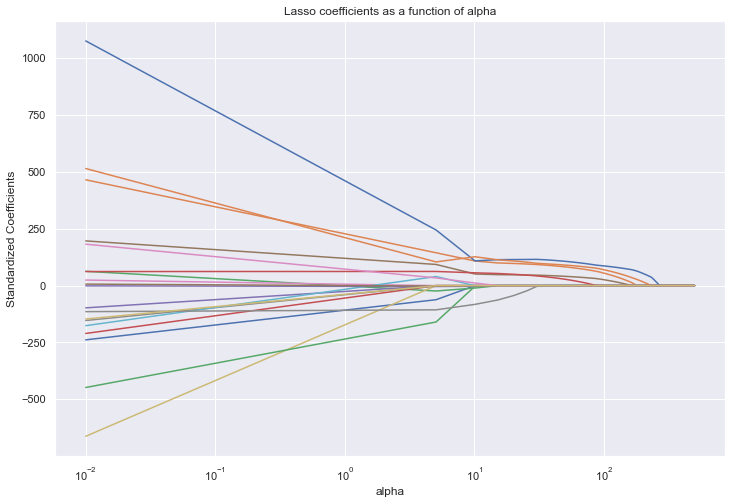

In [50]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Cada curva nesse gráfico é um coeficiente de um dos regressores (preditores) em função do parâmetro de regularização $\alpha$. Lembre-se que se $\alpha = 0$, então o LASSO nos dá os coeficiente do modelo de OLS, enquanto quando $\alpha \rightarrow \infty$, o LASSO nos entrega coeficientes nulos.

Dessa forma, ao olharmos para o gráfico da esquerda para a direita, temos que os coeficientes apresentam alta magnitude e conforme $\alpha$ cresce, esses parâmetros vão em direção à zero.

Agora usaremos cross-validation para encontrar o melhor valor de $\alpha$.

### LASSO com o melhor $\alpha$

Para encontrar o valor ótimo de $\alpha$, usaremos o modelo linear do LASSO da biblioteca scikit learns com ajuste interativo ao longo do caminho de regularização (LassoCV). O melhor modelo é selecionado por cross-validation.

#### k-fold cross-validation

In [51]:
from sklearn.linear_model import LassoCV

# Lasso com 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Ajuste do modelo
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [52]:
# mostra o valor ótimo de alpha escolhido por cross-validation
model.alpha_

2.3441244939374584

#### Melhor Modelo

Usando o valor ótimo de alpha para o nosso modelo final

In [53]:
# usando o alpha ótimo
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=2.3441244939374584)

In [55]:
# lista dos coeficientes escolhidos pelo modelo do LASSO com o valor ótimo de alpha
list(zip(lasso_best.coef_, X))

[(-176.45309657050367, 'AtBat'),
 (271.2333327634519, 'Hits'),
 (-13.04949222304172, 'HmRun'),
 (-48.97878412496708, 'Runs'),
 (-13.83696437015512, 'RBI'),
 (140.12896436568226, 'Walks'),
 (-10.616534012349028, 'Years'),
 (-0.0, 'CAtBat'),
 (0.0, 'CHits'),
 (78.65781330867236, 'CHmRun'),
 (355.66188056426284, 'CRuns'),
 (60.50548334807058, 'CRBI'),
 (-262.7512352402532, 'CWalks'),
 (65.61587416521267, 'PutOuts'),
 (-0.14505342495248086, 'Assists'),
 (-1.2293157493169844, 'Errors'),
 (99.66112742179934, 'League_N'),
 (-116.8640556916492, 'Division_W'),
 (-69.87497671182548, 'NewLeague_N')]

#### Avaliação do Modelo

In [56]:
print('R^2 do conjunto de dados de treino', round(lasso_best.score(X_train, y_train)*100, 2))
print('R^2 do conjunto de dados de teste', round(lasso_best.score(X_test, y_test)*100, 2))

R^2 do conjunto de dados de treino 59.18
R^2 do conjunto de dados de teste 35.48


In [117]:
round(mean_squared_error(y_test, lasso_best.predict(X_test)), 2)

129468.6

caminho do LASSO: plota os resultados da cross-validation com os MSEs

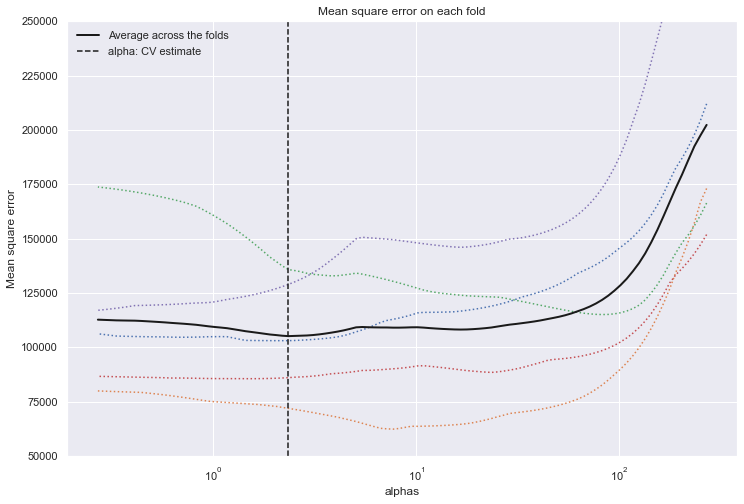

In [58]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);

### Regressão OLS

In [87]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,0.644577,0.257439,-0.456963,0.101010,-0.763917,-0.975959,-0.070553,0.298535,0.239063,-0.407836,0.011298,-0.163736,-0.361084,-0.482387,1.746229,3.022233,1,1,1
92,-0.592807,-0.671359,-0.572936,-0.778318,-0.685806,-0.458312,-1.306911,-1.001403,-0.969702,-0.746705,-0.957639,-0.898919,-0.844319,-0.851547,0.022276,2.574735,0,0,0
137,-0.413075,-0.105019,-0.688910,-0.258715,-0.646751,-0.081841,1.577925,0.717456,0.706633,-0.010542,0.645511,0.259369,0.220252,-0.294452,-0.434676,0.635577,0,0,0
90,-0.613545,-0.558091,0.122907,-0.618440,-0.256196,-1.211253,-0.482672,-0.514087,-0.478077,-0.501317,-0.602362,-0.526826,-0.684451,0.786178,-0.545452,-0.706917,0,1,0
100,0.637665,0.982354,0.586803,0.260888,1.227914,1.706394,0.547626,1.267183,1.437305,2.384908,1.535171,2.041811,1.615457,2.504446,-0.213124,0.635577,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.824309,0.733164,0.470829,0.740521,0.954525,0.859335,-0.688732,-0.824858,-0.808834,-0.571428,-0.787341,-0.685866,-0.648118,3.427344,0.326910,1.232241,1,0,1
196,0.423369,0.461321,1.862516,0.500704,1.618469,0.482865,1.165805,1.354814,1.246368,1.625375,1.112362,1.516681,0.681687,-1.002566,-0.822392,-1.303581,0,1,0
159,1.474109,1.254197,1.746542,1.140215,2.126191,-0.458312,-0.894792,-0.522636,-0.520174,-0.068968,-0.528958,-0.322776,-0.662651,-0.633407,1.310048,0.933909,0,1,0
17,-1.470728,-1.396275,-1.152806,-1.217982,-1.740306,-1.258312,-0.482672,-0.932153,-0.933620,-0.770075,-0.869554,-0.934928,-0.818885,-0.660255,0.403069,1.083075,0,1,0


In [88]:
OLS_reg = pd.DataFrame()

OLS_reg['AtBat'] = X_train['AtBat']
OLS_reg['Hits'] = X_train['Hits']
OLS_reg['HmRun'] = X_train['HmRun']
OLS_reg['Runs'] = X_train['Runs']
OLS_reg['RBI'] = X_train['RBI']
OLS_reg['Walks'] = X_train['Walks']
OLS_reg['Years'] = X_train['Years']
OLS_reg['CAtBat'] = X_train['CAtBat']
OLS_reg['CHits'] = X_train['CHits']
OLS_reg['CHmRun'] = X_train['CHmRun']
OLS_reg['CRuns'] = X_train['CRuns']
OLS_reg['CRBI'] = X_train['CRBI']
OLS_reg['CWalks'] = X_train['CWalks']
OLS_reg['PutOuts'] = X_train['PutOuts']
OLS_reg['Assists'] = X_train['Assists']
OLS_reg['Errors'] = X_train['Errors']
OLS_reg['League_N'] = X_train['League_N']
OLS_reg['Division_W'] = X_train['Division_W']
OLS_reg['NewLeague_N'] = X_train['NewLeague_N']
OLS_reg['Salary'] = y_train

In [92]:
result = sm.ols(formula="Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + PutOuts + Assists + Errors + League_N + Division_W + NewLeague_N", data=OLS_reg).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     13.62
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           7.80e-25
Time:                        13:23:51   Log-Likelihood:                -1298.6
No. Observations:                 184   AIC:                             2637.
Df Residuals:                     164   BIC:                             2701.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     572.8449     41.337     13.858      

In [96]:
result.params

Intercept       572.844899
AtBat          -238.979601
Hits            467.686520
HmRun            64.011368
Runs           -212.144568
RBI             -98.719329
Walks           197.290955
Years            24.778915
CAtBat         -150.031844
CHits          -676.702531
CHmRun         -180.479823
CRuns          1085.916056
CRBI            522.356630
CWalks         -450.286387
PutOuts          61.939123
Assists          -1.175418
Errors            6.950576
League_N        182.675058
Division_W     -114.396276
NewLeague_N    -146.949235
dtype: float64

In [99]:
OLS_reg['Salary_estimates'] = result.params[0] + result.params[1]*OLS_reg['AtBat'] + result.params[2]*OLS_reg['Hits'] + \
                              result.params[3]*OLS_reg['HmRun'] + result.params[4]*OLS_reg['Runs'] + result.params[5]*OLS_reg['RBI'] + \
                              result.params[6]*OLS_reg['Walks'] + result.params[7]*OLS_reg['Years'] + result.params[8]*OLS_reg['CAtBat'] + \
                              result.params[9]*OLS_reg['CHits'] + result.params[10]*OLS_reg['CHmRun'] + result.params[11]*OLS_reg['CRuns'] + \
                              result.params[12]*OLS_reg['CRBI'] + result.params[13]*OLS_reg['CWalks'] + result.params[14]*OLS_reg['PutOuts'] + \
                              result.params[15]*OLS_reg['Assists'] + result.params[16]*OLS_reg['Errors'] + result.params[17]*OLS_reg['League_N'] + \
                              result.params[18]*OLS_reg['Division_W'] + result.params[19]*OLS_reg['NewLeague_N']

Vamos encontrar o MSE do modelo de OLS para comparar com o LASSO. Primeiro, vale lembrar a fórmula do MSE:

$$
\operatorname{MSE} = \frac{1}{n} \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2
$$

In [112]:
def MSE(y, y_hat, n):
    M = (1 / n) * ( ( (y - y_hat)**2 ).sum() )
    return round(M, 2)

In [113]:
# MSE nos dados de treino
MSE(OLS_reg['Salary'], OLS_reg['Salary_estimates'], len(OLS_reg))

78990.63

In [114]:
OLS_reg_test = pd.DataFrame()

OLS_reg_test['AtBat'] = X_test['AtBat']
OLS_reg_test['Hits'] = X_test['Hits']
OLS_reg_test['HmRun'] = X_test['HmRun']
OLS_reg_test['Runs'] = X_test['Runs']
OLS_reg_test['RBI'] = X_test['RBI']
OLS_reg_test['Walks'] = X_test['Walks']
OLS_reg_test['Years'] = X_test['Years']
OLS_reg_test['CAtBat'] = X_test['CAtBat']
OLS_reg_test['CHits'] = X_test['CHits']
OLS_reg_test['CHmRun'] = X_test['CHmRun']
OLS_reg_test['CRuns'] = X_test['CRuns']
OLS_reg_test['CRBI'] = X_test['CRBI']
OLS_reg_test['CWalks'] = X_test['CWalks']
OLS_reg_test['PutOuts'] = X_test['PutOuts']
OLS_reg_test['Assists'] = X_test['Assists']
OLS_reg_test['Errors'] = X_test['Errors']
OLS_reg_test['League_N'] = X_test['League_N']
OLS_reg_test['Division_W'] = X_test['Division_W']
OLS_reg_test['NewLeague_N'] = X_test['NewLeague_N']
OLS_reg_test['Salary'] = y_test

In [115]:
OLS_reg_test['Salary_estimates'] =  result.params[0] + result.params[1]*OLS_reg_test['AtBat'] + result.params[2]*OLS_reg_test['Hits'] + \
                                    result.params[3]*OLS_reg_test['HmRun'] + result.params[4]*OLS_reg_test['Runs'] + result.params[5]*OLS_reg_test['RBI'] + \
                                    result.params[6]*OLS_reg_test['Walks'] + result.params[7]*OLS_reg_test['Years'] + result.params[8]*OLS_reg_test['CAtBat'] + \
                                    result.params[9]*OLS_reg_test['CHits'] + result.params[10]*OLS_reg_test['CHmRun'] + result.params[11]*OLS_reg_test['CRuns'] + \
                                    result.params[12]*OLS_reg_test['CRBI'] + result.params[13]*OLS_reg_test['CWalks'] + result.params[14]*OLS_reg_test['PutOuts'] + \
                                    result.params[15]*OLS_reg_test['Assists'] + result.params[16]*OLS_reg_test['Errors'] + result.params[17]*OLS_reg_test['League_N'] + \
                                    result.params[18]*OLS_reg_test['Division_W'] + result.params[19]*OLS_reg_test['NewLeague_N']

In [116]:
# MSE nos dados de teste
MSE(OLS_reg_test['Salary'], OLS_reg_test['Salary_estimates'], len(OLS_reg_test))

148398.94

Resumindo os resultados, encontramos que o OLS entrega um MSE de $148398.94$, enquanto o LASSO com $\alpha = 1$ tem MSE de $134426.33$ e por fim, usando o valor ótimo do parâmetro de regularização $\alpha = 2.34$ nos entrega $129468.6$.

Vamos agora verificar como o coeficiente R-squared $R^2$ do modelo OLS se comporta. Novamente usaremos uma fórmula para encontrar tal medida.

$$
\begin{align}
R^2 &= \frac{\operatorname{ESS}}{\operatorname{TSS}} \\
&= 1 - \frac{\operatorname{RSS}}{\operatorname{TSS}} 
\end{align}
$$

onde 

$$
\operatorname{ESS} = \sum_{i=1}^n \left(\hat{y}_i - \bar{y}\right)^2
$$ 

é o Explained Sum of Squares, 

$$
\operatorname{RSS} = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2
$$ 

é o Residual Sum of Squares e 

$$
\operatorname{TSS} = \sum_{i=1}^n \left(y_i - \bar{y}\right)^2
$$

é o Total Sum of Squares.

In [139]:
def R2(y, y_hat):
    y_bar = y.mean()
    RSS = ( ( y - y_hat )**2 ).sum()
    TSS = ( ( y - y_bar )**2 ).sum()
    R = 1 - ( RSS / TSS )
    return round(R * 100, 2)

In [140]:
# R2 nos dados de treino
R2(OLS_reg['Salary'], OLS_reg['Salary_estimates'])

61.21

In [141]:
# R2 nos dados de teste
R2(OLS_reg_test['Salary'], OLS_reg_test['Salary_estimates'])

26.04

Resumindo os resultados, encontramos que o OLS entrega um R-squared de $26.04$, enquanto o LASSO com $\alpha = 1$ tem R-squared de $33.01$ e por fim, usando o valor ótimo do parâmetro de regularização $\alpha = 2.34$ nos entrega $35.48$.